# Problem Set 2

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import loadmat
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from time import process_time_ns

## Load and plot the grids

In [2]:
grids = loadmat('FE_grid.mat',simplify_cells=True)
#print(grids['FE_grid'].keys())
print(grids.keys())
coarse_grid = grids['FE_grid']['coarse']
# show the keys in the grid
print(coarse_grid.keys())
print("number of nodes:",coarse_grid['nodes'])
print("number of elements:",coarse_grid['elements'])
x=coarse_grid['coor'][:,0]
y=coarse_grid['coor'][:,1]
z=np.sin(np.pi*x)*np.cos(np.pi*y)
# be careful  the indices must start at 0, in mat files they start at one, so substract 1
triangles=np.concatenate(coarse_grid['theta'][0:5]-1)
T=tri.Triangulation(x,y,triangles)


dict_keys(['__header__', '__version__', '__globals__', 'FE_grid'])
dict_keys(['nodes', 'coor', 'elements', 'theta'])
number of nodes: 1333
number of elements: 2095


In [3]:
def plot(mesh,u):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs = axs.flatten()

    # Plot the triangulation.
    axs[0].triplot(mesh)
    axs[0].set_title('Triangular grid')

    # Plot the color map.
    axs[1].tricontourf(mesh,u)
    axs[1].set_title('color map of z')
    fig.tight_layout()
    plt.show()
#plot(T,z)

# Load the matrices

In [4]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
Aq_coarse=M['FE_matrix']['coarse']['Ahq']
Fh_coarse=M['FE_matrix']['coarse']['Fh']

## Solve the finite element problem

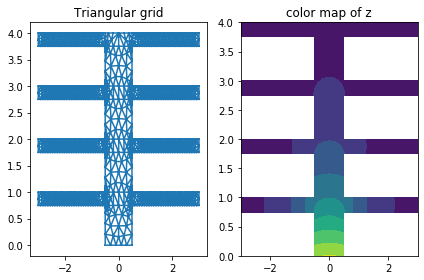

In [5]:
def assembleA(mu,Aq):
    #if sparse:
    A=csc_matrix(np.shape(Aq[0]))#modifié
    #else:
        #A=np.ndarray(np.shape(Aq))
        
    for k in range(0,6):
        A+=mu[k]*Aq[k]
    return A
k_i=1
Bi=0.1
mu=np.array([k_i,k_i, k_i, k_i, 1, Bi])
A=assembleA(mu,Aq_coarse)
u = spsolve(A, Fh_coarse)
plot(T,u)

We saw in class that the reduced basis solution $u_N (\mu) ∈ R^N$ satisfies the set of $N \times N$ linear equations,

$$A_N(\mu)u_N(\mu) = F_N ; \quad \quad (1)$$

and that the output is given by:
    
$$T_{root}^N (\mu) = L^T_N u_N (\mu). \quad \quad (2)$$

We derived expressions for $A_N (μ) ∈ R^{N \times N}$ in terms of A_{\cal N }(μ) and Z, $F_N ∈ R^N$ in terms of $F_{\cal N}$ and
Z, and $L_N ∈ R^N$ in terms of $L_{cal N}$ and Z; here Z is an $\cal N \times N$ matrix, the jth column of which is $u_N (\mu_j)$ (the nodal values of $u_N (\mu_j)$). Finally, it follows from affine parameter dependence that $A_N (\mu)$ can be
expressed as:

    
$$A_N (\mu) =\sum_{q=1}^Q \Theta^q(\mu)A^q_N . \quad \quad (3)$$

The goal is to implement an offline/ online version of the reduced – basis method following the computational decomposition indicated below:


• **Offline**

1/ Choose N. 

2/ Choose the sample $S_N$. 

3/ Construct Z. 

4/ Construct: $A^q_N$ , $q = 1, . . . , Q$; $F_N$ ; and $L_N$ .

• **Online**

1/ Form $A_N(\mu)$ from (3).

2/ Solve $A_N(\mu)u_N(\mu) = F_N$ .

3/ Evaluate the output $T_root^N (\mu)$ from (2).


# Question 1: 

The idea is that the offline stage is done only once, generating a small datafile with the $A^q_N , q = 1, . . . ,Q,$
$F_N$ , and $L_N$ ; the on-line stage then accesses this datafile to provide real-time response to new $\mu$ queries.
For the required off-line finite element calculations in this and the following questions, we first
use the coarse triangulation $T_{h,coarse}$ .

## Question a:

Show that the operation count for the on-line stage of your code is independent of {\cal N} . In particular
show that the operation count (number of floating-point operations) for the on-line stage, for each new $\mu$ of interest, can be expressed as:
$$c_1 N^{γ_1} + c_2 N^{γ_2} + c_3 N^{γ_3} , \quad \quad (4)$$

for $c_1 , c_2 , c_3 , γ_1 , γ_2$ , and $γ_3$ independent of ${N}$ . Give values for the constants $c_1 , c_2 , c_3 , γ_1 , γ_2 ,$ and $γ_3$ .

To answer this question we assume the addition and multiplication count as the same floating point operations.

* **For forming A:**

The $N \times N$ matrix $A_{N}(\mu)$ can be expressed according to (3) as:
    
$$A_N (\mu) =\sum_{q=1}^Q \Theta^q(\mu)A^q_N . \quad \quad (3)$$

Which requires $$(Q−1)N^2 = 5*N^2 additions + QN^2 = 6*N^2 multiplications$$ 

$$ \iff 11*N^2$$  


* **For solving AX=b:**
    
We consider that $A$ is a dense matrix, thus  a set of linear equations Ax = b, with A nonsingular requires:
    
* LU factorization. Factor A as $A = P LU$ ((2/3)n3 flops).
* Permutation. Solve $P z_1 = b$ (0 flops).
* Forward substitution. Solve $Lz_2 = z1$ (($\frac {N(N-1)}{2}$ -1 flops). (-1 due to 1 in the diagonal)
* Backward substitution. Solve $Ux = z2$ ($\frac {N(N+1)}{2}$ + N flops). (+ N because of the diagonal)
                                               
Thus the total cost is: $$\frac{2}{3} N^3 +N^2+N-1$$

* **To evaluate the output Troot:**
    
This is the cost for the calculation of the inner product, there are N multiplications and N −1 additions,
a total of: $$2N − 1 \quad operations.$$

So the total cost for the on-line stage for each new \mu of interest is:

$$\frac{2}{3} N^3 +N^2+11*N^2+ N-1 +2N − 1$$ 

Which is in fact:

$$ \frac{2}{3} N^3 +12*N^2+ 3N - 2 \quad flops$$

Thus the given parameters in (4) are as follows:
    
$$c_1 = \frac{2}{3}, c_2=12 , c_3 =3$$

and $$γ_1=3 , γ_2=2 , γ_3 = 1$$ 

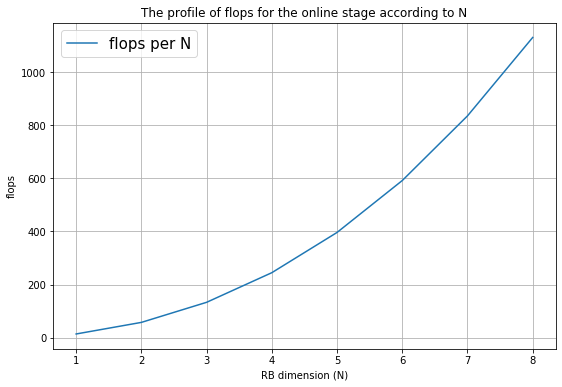

In [89]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension (N)', ylabel='flops', \
       title= "The profile of flops for the online stage according to N")

def expected_flops(N):
    return 2/3 * N**3 + 12*N**2 + 3*N - 2
N = np.arange(1,9)
ax.plot(N,expected_flops(N),label=r"flops per N")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Comment:**

As we can see the operation count is independent of $\cal N$. Also the parameters are independant of N. The number of flops is $O(N^3 + N^2 + N).$

## Question b:

In [138]:
mu_sample = loadmat('RB_sample.mat')['RB_sample']['sample1'][0][0][0]
N = 8
Q= 6
Z = np.ndarray((coarse_grid['nodes'],N))

#### Question 1:

**Generate the reduced basis matrix Z**

We have two options: you can use the solution ”snapshots” directly in Z or perform a Gram-Schmidt orthonor-
malization to construct Z (Note that you require the X – inner product to perform Gram-Schmidt;
here, we use (·, ·) X = a(·, ·; μ), where μ = 1 all conductivities are 1 and the Biot number is 0.1).


**Snapshots with $\bar{\mu} = 1$**

**Offline operationes**

In [182]:
Z = np.ndarray((coarse_grid['nodes'],N))
for i in range(N):
    mu=np.array([mu_sample[i],mu_sample[i], mu_sample[i], mu_sample[i], 1, Bi])
    A=assembleA(mu,Aq_coarse)
    u = spsolve(A, Fh_coarse)
    Z[:,i] = u[:]
Z.shape,A.shape,u.shape

((1333, 8), (1333, 1333), (1333,))

In [183]:
#Z

**All necessary reduced basis quantities:**

**$A_q$**

In [184]:
Aq = np.ndarray((Q,N,N))
for i in range(Q):
    Aq[i,:,:] = Z.T @ Aq_coarse[i] @ Z

**Online stage**

**$A_N$**

In [192]:
#mu=np.array([1,1,1,1,1, Bi])
#mu=np.array([10,10,10,10,1., Bi])
#mu=np.array([0.1,0.1,0.1,0.1,1, Bi])
mu=np.array([0.10975,0.10975,0.10975,0.10975,1, Bi])
A_N = assembleA(mu,Aq)

**Fh**

In [193]:
Fh = np.ndarray(N)
Fh = Z.T @ Fh_coarse

**L_N**

In [194]:
L_N = np.ndarray(N)
L_N = Fh.T

In [195]:
Aq.shape, Fh.shape, L_N.shape

((6, 8, 8), (8,), (8,))

In [196]:
cond_A_N = np.linalg.cond(A_N)

In [197]:
cond_A_N 

1188165649054.6016

**$U_N$**

In [198]:
U_N = np.linalg.solve(A_N, Fh)
U_N

array([ 2.36084868e-05, -6.74397524e-07, -1.09437269e-05,  2.12453942e-06,
        5.11318711e-05,  2.57296906e-06, -1.89074733e-06,  9.99934071e-01])

**Gram-Schmidt orthonormalization**

### Inner product

In [133]:
# def Gram_Schmidt(A,u):
#     v = np.zeros_like(u)
#     v[:,0] = u[:,0]
#     for i in range(1,u.shape(1)):
#         v[:,i] = u[:,i]
#         for k in range(i):
#             v[:,i]-=inner_prod(A,u[:,i],u[:,k])*u[:,k]
#         v[:,i] = v[:,i]/np.sqrt(inner_prod(A,u[:,i],u[:,i]))

In [134]:
def inner_prod_A(u,v):
    mu=np.array([1,1,1,1,1, Bi])
    A=assembleA(mu,Aq_coarse)
    return u.T@A@v

def Gram_Schmidt_inplace(A,u,i):
    v = u.copy()
    for k in range(i):
        v[:,i]-=inner_prod_A(u[:,i],u[:,k])*u[:,k]
    v[:,i] = v[:,i]/np.sqrt(inner_prod_A(v[:,i],v[:,i]))
    return v[:,i]

In [108]:
def test_Gram(Z):
    verif = []
    for i in range(N):
        for j in range(i+1):
            verif.append(inner_prod_A(Z[:,i],Z[:,j]))
    return np.array(verif)


**Offline**

In [200]:
Z = np.ndarray((coarse_grid['nodes'],N))
for i in range(N):
    mu=np.array([mu_sample[i],mu_sample[i], mu_sample[i], mu_sample[i], 1., Bi])
    A=assembleA(mu,Aq_coarse)
    u = spsolve(A, Fh_coarse)
    Z[:,i] = u[:]
    Z[:,i] =  Gram_Schmidt_inplace(A,Z,i)
        
Z.shape,A.shape,u.shape

((1333, 8), (1333, 1333), (1333,))

In [201]:
#Z
#test_Gram(Z.round(10))

**All necessary reduced basis quantities:**

**$A_q$**

In [202]:
Aq = np.ndarray((Q,N,N))
for i in range(Q):
    Aq[i,:,:] = Z.T @ Aq_coarse[i] @ Z

**Online**

**$A_N$**

In [203]:
#mu=np.array([1.5,1.5,1.5,1.5,1., Bi])
#mu=np.array([1.,1.,1.,1.,1., Bi])
mu=np.array([0.1,0.1,0.1,0.1,1, Bi])
#mu=np.array([10,10,10,10,1., Bi])
A_N = assembleA(mu,Aq)

**$F_h$**

In [204]:
Fh = np.ndarray(N)
Fh = Z.T @ Fh_coarse

**$L_N$**

In [205]:
L_N = np.ndarray(N)
L_N = Fh

In [206]:
Aq.shape, Fh.shape, L_N.shape

((6, 8, 8), (8,), (8,))

**$T^N_{root}$**

In [207]:
T_root = L_N.T@np.linalg.solve(A_N,Fh)
T_root

2.024994398156299

**Condition number**

In [208]:
cond_A_N = np.linalg.cond(A_N)

In [209]:
cond_A_N

9.333630191325058

**$U_N$**

In [210]:
U_N = np.linalg.solve(A_N, Fh)
U_N

array([ 1.91716756e+00, -3.36000251e-16, -5.63263508e-16, -9.57205207e-16,
        1.00393825e-15, -2.41397366e-15,  4.58253961e-16, -5.80678180e-16])

Calculate the condition number of $A_N (μ)$ for $N = 8$ and for $μ = 1$ and $μ = 10$ with and without
Gram – Schmidt orthonormalization. What do you observe? 

**Results:**

$$for: \, \, \mu= 1$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Z construction} & Snapshots & Orthonormalized \\
\hline
\text{Condition number} & 2.75\times10^{11} &1.000001 \\
\hline
\end{array}
$$
And:
$$for: \, \, \mu= 10$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Z construction} & Snapshots & Orthonormalized \\
\hline
\text{Condition number} & 1.34\times10^{11}&9.9 \\
\hline
\end{array}
$$

**Comments:**
    
Conditioning is much too important without orthonormalization, which could create instability phenomena when resolving the linear system. It is therefore in our interest to orthonormalize Z beforehand.

**Solve the reduced basis approximation (where you use the snapshots directly in Z) for $μ_1 = 0.1$ and $N = 8.$ What is $u_N (\mu_1)$?**

**Results: Snapshots**

Above in the **Snapshots section** with a value of $\mu = 0.1$, the obtained value of $U_N$ is $ (1, 0, . . . , 0).T$ with an accuracy of around $10^{−4}$. This is expected since $µ = 0.1$ corresponds exactly to one of the values we chose off-line in our sample for µ, in this case the first element of the sample. Similarly, for µ = 10, the vector $U_N$ is close to (0, 1, 0, . . . . , 0).T. For µ = 0.10975, we find (0, . . . , 0, 1).T

### Observation:

La matrice A_N obetenue par la matrice de passage Z orthonormé a un bon conditionnement ~ 1 alors que la matrice La matrice A_N obetenue par la matrice de passage Z 'Snapshots' est trés mauvais. 

**Results: orthonormalized**

In the above section of **orthonormalized Z construction** we solve $A_N(\mu) U_N= Fh$: 

for µ = 0.1, we find (1.9, . . . . , 0).T and for µ = 10, we find (0.78, 0.88, 0 . . . , 0).T to the precision $10^{14}$. The previous phenomenon has disappeared but these results with a lot of zeroes can still be explained. For the first value µ = 0.1, it is logical that only the first coefficient is non-zero, since the first base vector is equal to that of the non-orthonormalized base, to within one coefficient. For the value µ = 10, only the first two coefficients are non-zero: indeed, in view of the Gram-Schmidt algorithm, a linear combination of the first two base vectors makes it possible to find the second base vector of the non orthonormalized, which is indeed the one we are looking for. We also note that the zero coefficients are zero this time.

### Question 2:

In [30]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
Aq_coarse=M['FE_matrix']['coarse']['Ahq']
Fh_coarse=M['FE_matrix']['coarse']['Fh']
mu_sample = loadmat('RB_sample.mat')['RB_sample']['sample1'][0][0][0]

In [215]:
def offline_Z_ort(mu_sample,N):
    Z = np.ndarray((coarse_grid['nodes'],N))
    for i in range(N):
        mu=np.array([mu_sample[i],mu_sample[i], mu_sample[i], mu_sample[i], 1., Bi])
        A=assembleA(mu,Aq_coarse)
        u = spsolve(A, Fh_coarse)
        Z[:,i] = u[:]
        Z[:,i] =  Gram_Schmidt_inplace(A,Z,i)
        
        Aq = np.ndarray((Q,N,N))
        for i in range(Q):
            Aq[i,:,:] = Z.T @ Aq_coarse[i] @ Z
            
    return A,Z,Aq 

In [216]:
def online(mu,Aq):
    A_N = assembleA(mu,Aq)
    
    Fh = np.ndarray(N)
    Fh = Z.T @ Fh_coarse
    
    L_N = np.ndarray(N)
    L_N = Fh
    
    T_root = L_N.T@np.linalg.solve(A_N,Fh)
    
    return A_N,Fh,L_N,T_root

In [217]:
N=8
mu=np.array([1.5,1.5,1.5,1.5,1., Bi])

In [218]:
A,Z,Aq = offline_Z_ort(mu_sample,N)
A_N,Fh,L_N,T_root = online(mu,Aq)

In [219]:
T_root

1.531074970789642

**Comments:**
    
We verify that our functions above are working for a value that is not present in the sample. We also structure it by creating two functions: an off-line function that calculates the quantities necessary for a
sampling of the given parameters, an on-line one that returns the solution and the output for a given value of the parameters.


### Question 3: 

In [220]:
def inner_prod_A(u,v,triangulation='coarse'):
    mu=np.array([1,1,1,1,1, Bi])
    
    if triangulation=='medium':
        A=assembleA(mu,Aq_medium)
    elif triangulation == 'fine':
        A=assembleA(mu,Aq_fine)
    else:
        A=assembleA(mu,Aq_coarse)
    #print(u.shape)
    #print(v.shape)
    #print(A.shape)
    
    return u.T@A@v

In [221]:
def Gram_Schmidt_inplace(A,u,i,triangulation='coarse'):
    v = u.copy()
    for k in range(i):
        v[:,i]-=inner_prod_A(u[:,i],u[:,k],triangulation)*u[:,k]
    v[:,i] = v[:,i]/np.sqrt(inner_prod_A(v[:,i],v[:,i],triangulation))
    return v[:,i]

In [54]:
def erreur_energy_output(Aq_coarse,Fh_coarse,mu_sample,N,k1,triangulation='coarse'):
    ##############################################################
    ######################offline#################################
    ##############################################################
    offline_start = process_time_ns() 
    
    if triangulation=='medium':
        N_cal = grids['FE_grid']['medium']['nodes']
    elif triangulation == 'fine':
        N_cal = grids['FE_grid']['fine']['nodes']
    else:
        N_cal = grids['FE_grid']['coarse']['nodes']
        
    Z = np.zeros((N_cal,N))
    #calcul de Z
    for i in range(N):
        mu=np.array([mu_sample[i],mu_sample[i], mu_sample[i], mu_sample[i], 1., Bi])
        A=assembleA(mu,Aq_coarse)
        u = spsolve(A, Fh_coarse)
        Z[:,i] = u[:]
        Z[:,i] = Gram_Schmidt_inplace(A,Z,i,triangulation)
    #print(Z)
    #calcul de A_q et A_N
    Aq = np.ndarray((Q,N,N))
    for i in range(Q):
        Aq[i,:,:] = Z.T @ Aq_coarse[i] @ Z
        
    offline_stop = process_time_ns() 
    offline_time = offline_stop - offline_start
    
    ################################################################
    ##########################online################################
    ################################################################
    online_start = process_time_ns()
    
    mu_test = np.array([k1,k1, k1, k1, 1., Bi])
    A=assembleA(mu_test,Aq_coarse)
    A_N = assembleA(mu_test,Aq)
    #calcul de Fh
    Fh = np.ndarray(N)
    Fh = Z.T @ Fh_coarse.T
    #calcul de u
    U_N = Z@np.linalg.solve(A_N,Fh)
    U =  spsolve(A,Fh_coarse)
    #nergy error
    U_norm = np.sqrt(U.T@A@U)
    erreur = U-U_N
    erreur = np.sqrt(erreur.T@A@erreur)
    erreur_energy = erreur/U_norm
    #Troot erreur
    UN = np.linalg.solve(A_N,Fh)
    T_root_N = Fh.T@UN
    T_root = Fh_coarse.T@U
    erreur_root = np.abs(T_root - T_root_N)/T_root
    
    online_stop = process_time_ns() 
    online_time = online_stop - online_start
    
    return erreur_energy,erreur_root,offline_time,online_time


In [55]:
test = np.linspace(0.1,10,100)
erreur_energy = []
erreur_output = []
offline = []
online = []
for N in range(1,9):
    erreur_u = 0
    erreur_T = 0
    on = 0
    off = 0
    
    for k1 in test:
        ###########################################
        ########Evaluation des erreurs#############
        ###########################################
        u,T,offline_time,online_time = erreur_energy_output(Aq_coarse,Fh_coarse,mu_sample,N,k1)
        erreur_u = np.maximum(u,erreur_u)
        erreur_T = np.maximum(T,erreur_T)
        ############################################
        ############Average cpu time################
        ############################################
        on +=  online_time
        off += offline_time
        
    offline.append(off/len(test))
    online.append(on/len(test))
    
    erreur_energy.append(erreur_u)    
    erreur_output.append(erreur_T)

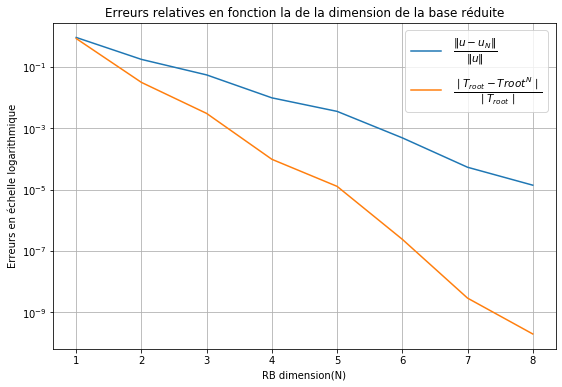

In [56]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")
ax.plot(range(1,9),erreur_energy,label=r"$\frac {\left \Vert u - u_N \right \Vert}{\left \Vert u  \right \Vert}$")
ax.plot(range(1,9),np.array(erreur_output),label=r"$\frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

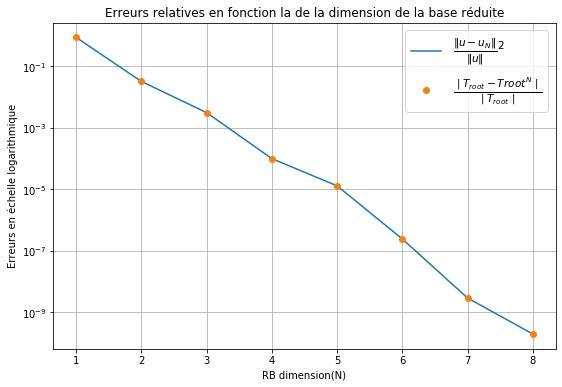

In [57]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")
ax.plot(range(1,9),np.array(erreur_energy)**2,label=r"${\frac {\left \Vert u - u_N \right \Vert}{\left \Vert u  \right \Vert}}^2$")
ax.plot(range(1,9),np.array(erreur_output),'o',label=r"$\frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Commentaire:**
    
Ceci n'est pas étonnat car on l'a démontré sur le pb 1.
En effet:$${\frac {\left \Vert u - u_N \right \Vert}{\left \Vert u  \right \Vert}}^2 = \frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}.$$

## Question 4: 

**Compare the average CPU time over the test sample required to solve the reduced basis online
stage with direct solution of the FE approximation as a function of N .**

La fonction utilisée est **time.process_time_ns() → int (at least Python3.3)** which
returns the value (in fractional seconds) of the sum of the system and user CPU time of the current process. It does not include time elapsed during sleep. It is process-wide by definition. The reference point of the returned value is undefined, so that only the difference between the results of consecutive calls is valid. **This means that other processes running on the same computer does not interfere with the timing**.

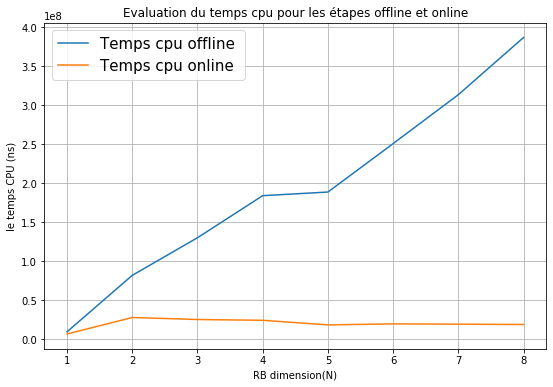

In [58]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
ax.plot(range(1,9),offline,label=r"Temps cpu offline ")
ax.plot(range(1,9),online,label=r"Temps cpu online")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

## Question 5:

**What value of N do you require to achieve a relative accuracy in the output of 1%.** 

l'erreur suivante est à l'odre de 1% :  0.031485642862804426


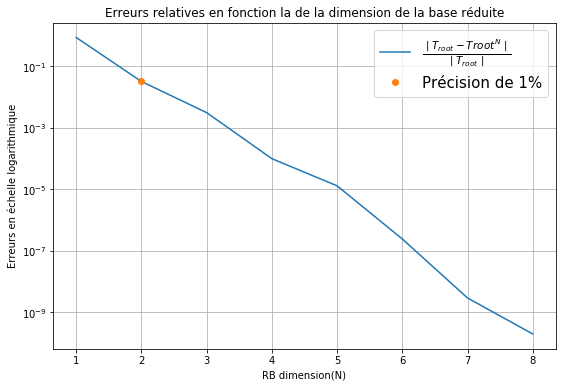

In [59]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")

ax.plot(range(1,9),np.array(erreur_output),label=r"$ \frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
#ax.plot(range(1,9),0.01*np.ones(8))
ax.plot(2,erreur_output[1],'o',label=r"Précision de 1%")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);
print("l'erreur suivante est à l'odre de 1% : ",erreur_output[1])

In [60]:
np.array(erreur_output)

array([8.50093209e-01, 3.14856429e-02, 3.05651526e-03, 9.73820270e-05,
       1.27549995e-05, 2.38457200e-07, 2.87491934e-09, 1.94345305e-10])

**Comentaire:**

La valeur de la dimension de la base réduite qui correspond à 1% est 3. Un assemblage de la matrice elements finis puis une résolution suivis d'une orthonormalisation est donc nécessaire au moins 3 fois en 3 valeurs $\mu$ différentes.

**What savings in terms of CPU time does this % correspond to?**

 Le temps CPU moyen 109748945.03


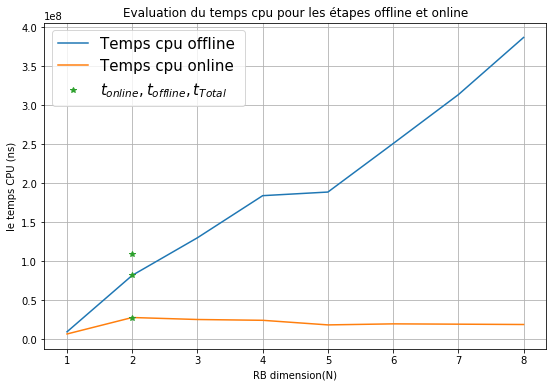

In [61]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
ax.plot(range(1,9),offline,label=r"Temps cpu offline ")
ax.plot(range(1,9),online,label=r"Temps cpu online")
ax.plot(2*np.ones(3),[online[1],offline[1],online[1]+offline[1]],'*',label=r"$t_{online},t_{offline},t_{Total}$")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);
print(" Le temps CPU moyen",online[1]+offline[1])

In [62]:
print("le temps CPU moyen total qui correspond à N=2 est : ", online[1]+offline[1] ,"ns")

le temps CPU moyen total qui correspond à N=2 est :  109748945.03 ns


In [63]:
print("le temps CPU moyen total qui correspond à N=8 est : ", online[7]+offline[7] ,"ns")

le temps CPU moyen total qui correspond à N=8 est :  405961031.60999995 ns


In [64]:
print("le gain en terme de temps CPU si l'on choisit N = 2 est de : ", 100*(online[7]+offline[7]-online[1]-offline[1])/(online[7]+offline[7]) ,"%")

le gain en terme de temps CPU si l'on choisit N = 2 est de :  72.96564534907529 %


**Comentaire:**
    
Le fait d'utiliser un N avec une précision de 1% nous permet de dde gagner ~82% du temps que l'on pouvait passer pour un N plus grand. Aussi, on remarque que le temps online est négligeable devant le temps offline d'où la force de la base réduite une fois on choisit une base rèduite.

## Question 6:

Solve problems b) 3. to 5. using the medium and fine FE triangulation. Is the dependence on N
as you would anticipate?

### Medium FE triangulation:

In [65]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
Aq_medium=M['FE_matrix']['medium']['Ahq']
Fh_medium=M['FE_matrix']['medium']['Fh']

In [66]:
test = np.linspace(0.1,10,100)
erreur_energy = []
erreur_output = []
offline = []
online = []
for N in range(1,9):
    erreur_u = 0
    erreur_T = 0
    on = 0
    off = 0
    
    for k1 in test:
        ###########################################
        ########Evaluation des erreurs#############
        ###########################################
        u,T,offline_time,online_time = erreur_energy_output(Aq_medium,Fh_medium,mu_sample,N,k1,'medium')
        erreur_u = np.maximum(u,erreur_u)
        erreur_T = np.maximum(T,erreur_T)
        ############################################
        ############Average cpu time################
        ############################################
        on +=  online_time
        off += offline_time
        
    offline.append(off/len(test))
    online.append(on/len(test))
    
    erreur_energy.append(erreur_u)    
    erreur_output.append(erreur_T)

#### Erreurs relatives

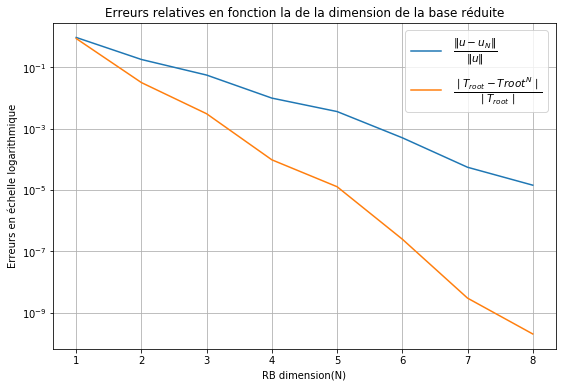

In [67]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")
ax.plot(range(1,9),erreur_energy,label=r"$\frac {\left \Vert u - u_N \right \Vert}{\left \Vert u  \right \Vert}$")
ax.plot(range(1,9),np.array(erreur_output),label=r"$\frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

#### Temps CPU

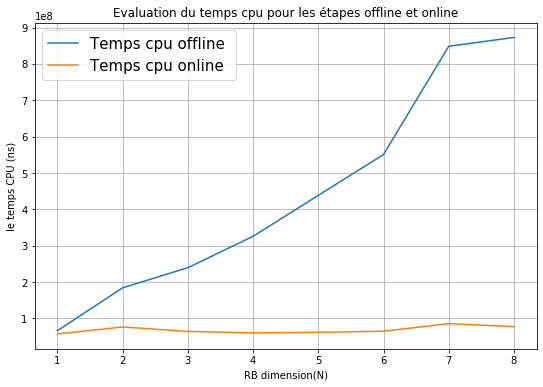

In [68]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
ax.plot(range(1,9),offline,label=r"Temps cpu offline ")
ax.plot(range(1,9),online,label=r"Temps cpu online")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

#### Choix de N

 Le temps CPU moyen 260801360.04000002 ns


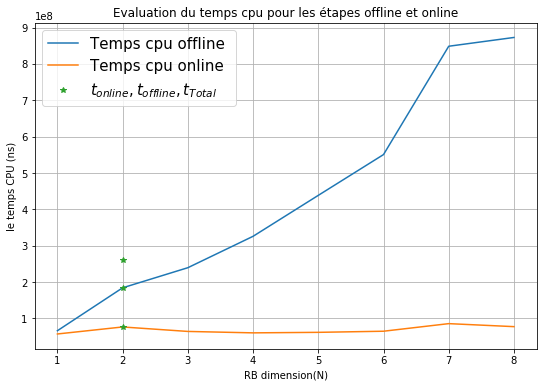

In [69]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
ax.plot(range(1,9),offline,label=r"Temps cpu offline ")
ax.plot(range(1,9),online,label=r"Temps cpu online")
ax.plot(2*np.ones(3),[online[1],offline[1],online[1]+offline[1]],'*',label=r"$t_{online},t_{offline},t_{Total}$")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);
print(" Le temps CPU moyen",online[1]+offline[1],"ns")

l'erreur suivante est à l'odre de 1% :  0.03128390713228578


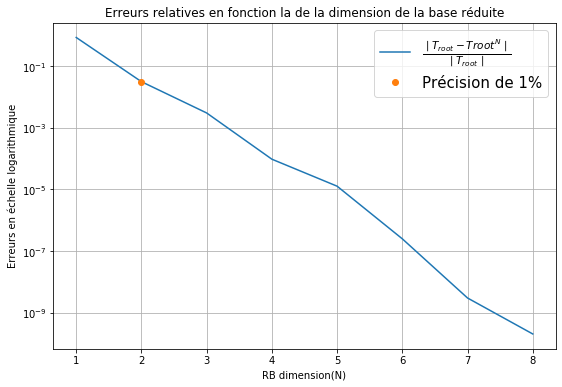

In [70]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")

ax.plot(range(1,9),np.array(erreur_output),label=r"$ \frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
#ax.plot(range(1,9),0.01*np.ones(8))
ax.plot(2,erreur_output[1],'o',label=r"Précision de 1%")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);
print("l'erreur suivante est à l'odre de 1% : ",erreur_output[1])

### Fine FE triangulation:

In [71]:
Aq_fine=M['FE_matrix']['fine']['Ahq']
Fh_fine=M['FE_matrix']['fine']['Fh']

In [72]:
test = np.linspace(0.1,10,100)
erreur_energy = []
erreur_output = []
offline = []
online = []
for N in range(1,9):
    erreur_u = 0
    erreur_T = 0
    on = 0
    off = 0
    
    for k1 in test:
        ###########################################
        ########Evaluation des erreurs#############
        ###########################################
        u,T,offline_time,online_time = erreur_energy_output(Aq_medium,Fh_medium,mu_sample,N,k1,'medium')
        erreur_u = np.maximum(u,erreur_u)
        erreur_T = np.maximum(T,erreur_T)
        ############################################
        ############Average cpu time################
        ############################################
        on +=  online_time
        off += offline_time
        
    offline.append(off/len(test))
    online.append(on/len(test))
    
    erreur_energy.append(erreur_u)    
    erreur_output.append(erreur_T)

#### Erreurs relatives

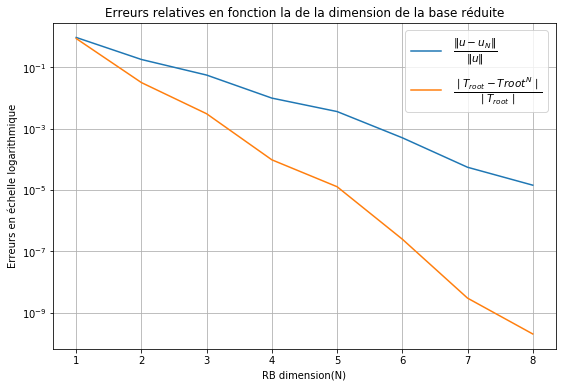

In [73]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")
ax.plot(range(1,9),erreur_energy,label=r"$\frac {\left \Vert u - u_N \right \Vert}{\left \Vert u  \right \Vert}$")
ax.plot(range(1,9),np.array(erreur_output),label=r"$\frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

#### Temps CPU

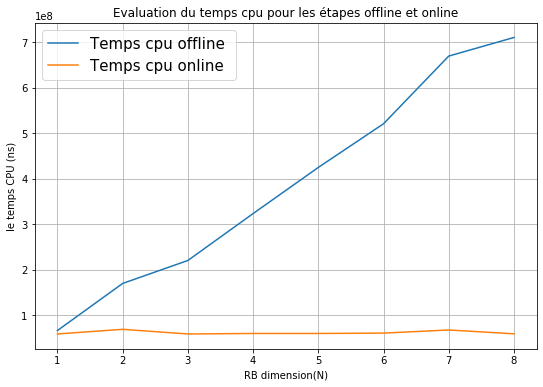

In [74]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
ax.plot(range(1,9),offline,label=r"Temps cpu offline ")
ax.plot(range(1,9),online,label=r"Temps cpu online")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

#### Choix de N

l'erreur suivante est à l'odre de 1% :  0.03128390713228578


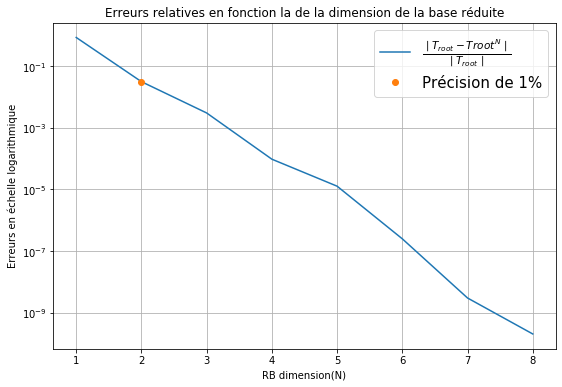

In [75]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")

ax.plot(range(1,9),np.array(erreur_output),label=r"$ \frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
#ax.plot(range(1,9),0.01*np.ones(8))
ax.plot(2,erreur_output[1],'o',label=r"Précision de 1%")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);
print("l'erreur suivante est à l'odre de 1% : ",erreur_output[1])

 Le temps CPU moyen 238290055.32 ns


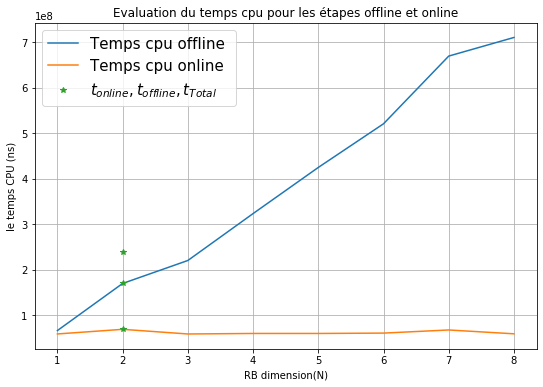

In [76]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
ax.plot(range(1,9),offline,label=r"Temps cpu offline ")
ax.plot(range(1,9),online,label=r"Temps cpu online")
ax.plot(2*np.ones(3),[online[1],offline[1],online[1]+offline[1]],'*',label=r"$t_{online},t_{offline},t_{Total}$")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);
print(" Le temps CPU moyen",online[1]+offline[1],"ns")

**Commentaire:**
Les erreurs relatives, les temps de cpu et aussi le choix de N est resté pareil indépendement de $N_{cal}$. Ceci est étonnant, je m'attendait au moins à un temps cpu plus élevé?!

# Question c:

We now consider another one parameter (P = 1) problem. This time, we assume that the conductivities
are fixed at {$k 1 , k 2 , k 3 , k $} = {$0.4, 0.6, 0.8, 1.2$}, and that only the Biot number, Bi, is allowed to vary
from 0.01 to 1. The sample set $S_N$ for $N_{max}$ = 11 is given in the datafile RB_sample.sample2. 

**Generate an orthonormal Z from the sample set using the medium triangulation.:**

In [383]:
def offline_output(Aq_coarse,Fh_coarse,mu_sample,N,triangulation='coarse'):
    ##############################################################
    ######################offline#################################
    ##############################################################
    offline_start = process_time_ns() 
    
    if triangulation=='medium':
        N_cal = grids['FE_grid']['medium']['nodes']
    elif triangulation == 'fine':
        N_cal = grids['FE_grid']['fine']['nodes']
    else:
        N_cal = grids['FE_grid']['coarse']['nodes']
        
    Z = np.zeros((N_cal,N))
    #calcul de Z
    for i in range(N):
        mu=np.array([0.4,0.6, 0.8, 1.2, 1., mu_sample[i]])
        A=assembleA(mu,Aq_coarse)
        u = spsolve(A, Fh_coarse)
        Z[:,i] = u[:]
        Z[:,i] = Gram_Schmidt_inplace(A,Z,i,triangulation)
    #print(Z)
    #calcul de A_q et A_N
    Aq = np.ndarray((Q,N,N))
    for i in range(Q):
        Aq[i,:,:] = Z.T @ Aq_coarse[i] @ Z
        
    offline_stop = process_time_ns() 
    offline_time = offline_stop - offline_start
    return A,Aq,Z,offline_time
    
    
def online_output(Aq_coarse,Fh_coarse,Z,Aq,mu,Bi):
    ################################################################
    ##########################online################################
    ################################################################
    online_start = process_time_ns()
    
    mu_test = np.array([0.4,0.6, 0.8, 1.2, 1., Bi])#mu
    A=assembleA(mu_test,Aq_coarse)
    A_N = assembleA(mu_test,Aq)
    #calcul de Fh
    Fh = np.ndarray(N)
    Fh = Z.T @ Fh_coarse.T
    #calcul de u
    U_N = Z@np.linalg.solve(A_N,Fh)
    U =  spsolve(A,Fh_coarse)
    #nergy error
    U_norm = np.sqrt(U.T@A@U)
    erreur = U-U_N
    erreur = np.sqrt(erreur.T@A@erreur)
    erreur_energy = erreur/U_norm
    #Troot erreur
    UN = np.linalg.solve(A_N,Fh)
    T_root_N = Fh.T@UN
    T_root = Fh_coarse.T@U
    erreur_root = np.abs(T_root - T_root_N)/T_root
    
    online_stop = process_time_ns() 
    online_time = online_stop - online_start
    
    
    return T_root_N,erreur_energy,erreur_root,online_time

In [384]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
Aq_medium=M['FE_matrix']['medium']['Ahq']
Fh_medium=M['FE_matrix']['medium']['Fh']

mu_sample2 = loadmat('RB_sample.mat')['RB_sample']['sample2'][0][0][0]
N = 11
Q= 6

**offline**

In [385]:
A,Aq,Z,offline_time = offline_output(Aq_medium,Fh_medium,mu_sample2,N,triangulation='medium')

**online**

In [386]:
mu = [0.4, 0.6, 0.8, 1.2, 1.,0.15]
Bi = 0.15

In [387]:
output=online_output(Aq_medium,Fh_medium,Z,Aq,mu,Bi)

**$T_{root}$**

In [388]:
T_root_N = output[0]

In [389]:
if(T_root_N.round(5)==1.51561):
    print("The root temperature is as expected in the verification question c/")
else:
    print("The result is not ok!!!!!!!")

The root temperature is as expected in the verification question c/


**Energy error and output error:**

In [390]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
Aq_medium=M['FE_matrix']['medium']['Ahq']
Fh_medium=M['FE_matrix']['medium']['Fh']

mu_sample2 = loadmat('RB_sample.mat')['RB_sample']['sample2'][0][0][0]
N = 11
Q= 6

In [400]:
test = np.linspace(0.01,1,100)
erreur_energy = []
erreur_output = []
offline = []
online = []
for N in range(1,12):
    erreur_u = 0
    erreur_T = 0
    on = 0
    off = 0
    ###############################################
    ################offline########################
    ###############################################
    A,Aq,Z,offline_time = offline_output(Aq_medium,Fh_medium,mu_sample2,N,triangulation='medium')
    
    for Bi in test:
        
        ###########################################
        ################online#####################
        ###########################################
        #T_root_N,erreur_energy,erreur_root,offline_time,online_time 
        output=online_output(Aq_medium,Fh_medium,Z,Aq,mu,Bi)
        
        ###########################################
        ########Evaluation des erreurs#############
        ###########################################
        u,T,online_time = output[1:]
        erreur_u = np.maximum(u,erreur_u)
        erreur_T = np.maximum(T,erreur_T)
        ############################################
        ############Average cpu time################
        ############################################
        on +=  online_time
        off += offline_time
        
    offline.append(off/len(test))
    online.append(on/len(test))
    
    erreur_energy.append(erreur_u)    
    erreur_output.append(erreur_T)

**Erreurs relatives**

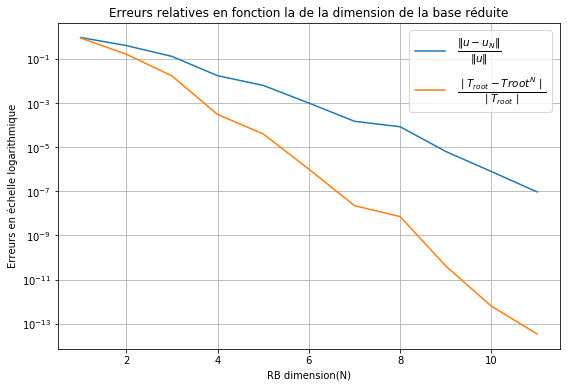

In [418]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")
ax.plot(range(1,12),erreur_energy,label=r"$\frac {\left \Vert u - u_N \right \Vert}{\left \Vert u  \right \Vert}$")
ax.plot(range(1,12),np.array(erreur_output),label=r"$\frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**CPU time:**

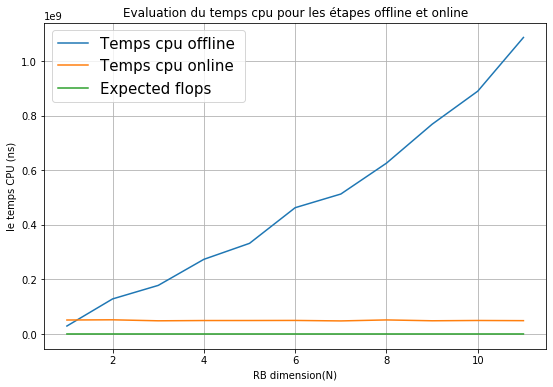

In [419]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
ax.plot(range(1,12),offline,label=r"Temps cpu offline ")
ax.plot(range(1,12),online,label=r"Temps cpu online")
ax.plot(range(1,12),expected_flops(np.arange(1,12)),label=r"Expected flops")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

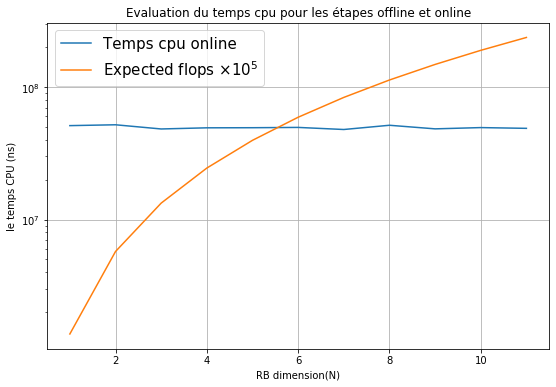

In [424]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
#ax.plot(range(1,12),offline,label=r"Temps cpu offline ")
ax.plot(range(1,12),online,label=r"Temps cpu online")
ax.plot(range(1,12),100000*expected_flops(np.arange(1,12)),label=r"Expected flops $\times 10^5$")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Comment:**
    
It is expected that the cpu time of the online stage is proportionnal to the expected number of floaps!!!!!! Something is wrong!!!!!!!!

**The Biot Number:**

The Biot number is directly related to the cooling method; higher cooling rates (higher Bi) imply
lower (better) T root but also higher (worse) initial and operational costs. We can thus define (say)
a total cost function as:

$$C(Bi) = Bi + T_{root}(Bi), \quad \quad (5)$$

In [457]:
def Costs(Aq_medium,Fh_medium,Z,Aq,mu,Bi):
    ###########################################
    ################online#####################
    ###########################################
    #T_root_N,erreur_energy,erreur_root,offline_time,online_time 
    output=online_output(Aq_medium,Fh_medium,Z,Aq,mu,Bi)

    ############################################
    ################T_root(Bi)##################
    ############################################
    T_root_Bi,u,T,online_time = output[:]
    
    return T_root_Bi

In [479]:
test = np.linspace(0.1,1,100)

C_Bi_list = []
###############################################
################offline########################
###############################################
A,Aq,Z,offline_time = offline_output(Aq_medium,Fh_medium,mu_sample2,N,triangulation='medium')

for Bi in test:
    T_root_Bi = Costs(Aq_medium,Fh_medium,Z,Aq,mu,Bi)
    C_Bi_list.append(T_root_Bi + Bi) 
    

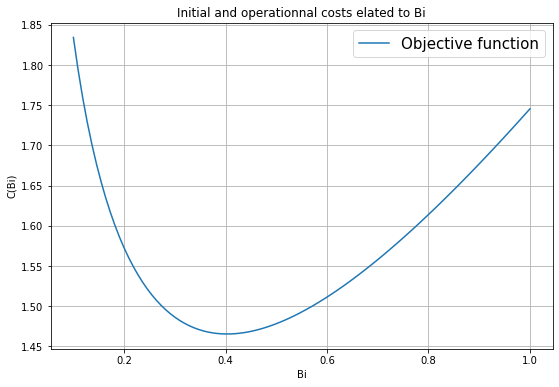

In [480]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='Bi', ylabel='C(Bi)', \
       title= "Initial and operationnal costs elated to Bi")

ax.plot(test,C_Bi_list,label=r"Objective function")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Simple optimization algorithme: Dechotomie**

In [481]:
def dechotomie(a,b):
    xx = []  # liste
    C_Bi_list = []
    
    x0 = a  # borne gauche de l'intervalle initial
    x1 = b  # borne droite de l'intervalle initial
    xx.append((x0+x1)/2.)  # ajouter a une liste
    C_Bi= Costs(Aq_medium,Fh_medium,Z,Aq,mu,xx[-1])+ xx[-1]
    C_Bi_list.append(C_Bi)
    compteur = 0
    while ((x1-x0) > 1e-10 and compteur < 100):
        xt0 = x0 + (x1-x0)/3.
        xt1 = x0 + 2*(x1-x0)/3.
        M0 = Costs(Aq_medium,Fh_medium,Z,Aq,mu,xt0)+ xt0#fun(xt0)
        M1 = Costs(Aq_medium,Fh_medium,Z,Aq,mu,xt1)+ xt1#fun(xt1)
        
        if M0 < M1:
            x1 = xt1

        elif M0 > M1:
            x0 = xt0
            
        else:
            x1 = xt1
            x0 = xt0
            

        xx.append((x0+x1)/2.)  # ajouter a une liste
        C_Bi= Costs(Aq_medium,Fh_medium,Z,Aq,mu,xx[-1])+ xx[-1]
        C_Bi_list.append(C_Bi)
        compteur = compteur+1

    if (compteur == 100):
        print("Maximum number of iteration reached (100)")
    print("Itereration number : ", compteur)

    xopt = (x0+x1)/2.

    print(u'The minimum value Bi=', xopt)
    xx = np.array(xx)  # transforme une liste en tableau
    return xx,C_Bi_list

In [482]:
Bi_list,C_Bi_list_opt = dechotomie(0.1,1)

Itereration number :  53
The minimum value Bi= 0.40295266107712424


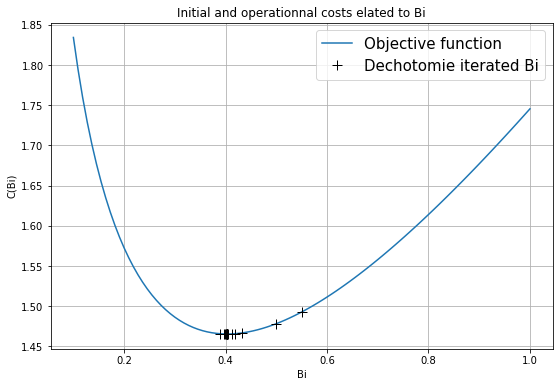

In [483]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='Bi', ylabel='C(Bi)', \
       title= "Initial and operationnal costs elated to Bi")

ax.plot(test,C_Bi_list,label=r"Objective function")
#ax.set_yscale('log')
ax.plot(Bi_list, C_Bi_list_opt, 'k+', markersize=10,label=r"Dechotomie iterated Bi")
ax.grid(True)
ax.legend(loc='best',fontsize=15);

In [485]:
print("The optimal value Bi_opt =", Bi_list[-1], "of cost =",C_Bi_list[-1])

The optimal value Bi_opt = 0.40295266107712424 of cost = 1.745429652985875


## Question d:

Finally, we consider a two parameter (P = 2) problem where the conductivities are assumed to be equivalent, i.e., k 1 = k 2 = k 3 = k 4 , but are allowed to vary between 0.1 and 10; and the Biot number, Bi, is allowed to vary from 0.01 to 1. The sample set $S_N$ for $N_{max} = 46$ is given in the datafile RB_sample.sample3. 

**Generate an orthonormal Z from the sample set using the coarse triangulation:**

In [516]:
def offline_output_2(Aq_coarse,Fh_coarse,mu_sample,N,triangulation='coarse'):
    ##############################################################
    ######################offline#################################
    ##############################################################
    offline_start = process_time_ns() 
    
    if triangulation=='medium':
        N_cal = grids['FE_grid']['medium']['nodes']
    elif triangulation == 'fine':
        N_cal = grids['FE_grid']['fine']['nodes']
    else:
        N_cal = grids['FE_grid']['coarse']['nodes']
        
    Z = np.zeros((N_cal,N))
    #calcul de Z
    for i in range(N):
        mu=np.array([mu_sample[0][i],mu_sample[0][i], mu_sample[0][i], mu_sample[0][i],1, mu_sample[1][i]])
        A=assembleA(mu,Aq_coarse)
        u = spsolve(A, Fh_coarse)
        Z[:,i] = u[:]
        Z[:,i] = Gram_Schmidt_inplace(A,Z,i,triangulation)
    #print(Z)
    #calcul de A_q et A_N
    Aq = np.ndarray((Q,N,N))
    for i in range(Q):
        Aq[i,:,:] = Z.T @ Aq_coarse[i] @ Z
        
    offline_stop = process_time_ns() 
    offline_time = offline_stop - offline_start
    return A,Aq,Z,offline_time
    
    
def online_output_2(Aq_coarse,Fh_coarse,Z,Aq,ki,Bi):
    ################################################################
    ##########################online################################
    ################################################################
    online_start = process_time_ns()
    
    mu_test = np.array([ki,ki,ki,ki,1, Bi])#mu
    A=assembleA(mu_test,Aq_coarse)
    A_N = assembleA(mu_test,Aq)
    #calcul de Fh
    Fh = np.ndarray(N)
    Fh = Z.T @ Fh_coarse.T
    #calcul de u
    U_N = Z@np.linalg.solve(A_N,Fh)
    U =  spsolve(A,Fh_coarse)
    #nergy error
    U_norm = np.sqrt(U.T@A@U)
    erreur = U-U_N
    erreur = np.sqrt(erreur.T@A@erreur)
    erreur_energy = erreur/U_norm
    #Troot erreur
    UN = np.linalg.solve(A_N,Fh)
    T_root_N = Fh.T@UN
    T_root = Fh_coarse.T@U
    erreur_root = np.abs(T_root - T_root_N)/T_root
    
    online_stop = process_time_ns() 
    online_time = online_stop - online_start
    
    
    return T_root_N,erreur_energy,erreur_root,online_time

**offline:**

In [521]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
Aq_coarse=M['FE_matrix']['coarse']['Ahq']
Fh_coarse=M['FE_matrix']['coarse']['Fh']

mu_sample3 = loadmat('RB_sample.mat')['RB_sample']['sample3'][0][0]
N = 46
Q= 6

In [522]:
mu_sample3_ki = mu_sample3[0]
mu_sample3_Bi = mu_sample3[1]

In [523]:
A,Aq,Z,offline_time = offline_output_2(Aq_coarse,Fh_coarse,mu_sample3,N,triangulation='coarse')

We next introduce a regular grid, Ξ test ⊂ D, of size ntest = 400 (a regular 20 × 20 grid).

### Relative errors:

In [524]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
Aq_coarse=M['FE_matrix']['coarse']['Ahq']
Fh_coarse=M['FE_matrix']['coarse']['Fh']

mu_sample3 = loadmat('RB_sample.mat')['RB_sample']['sample3'][0][0]
N = 46
Q= 6

In [551]:
test_Ki = np.linspace(0.1,10,20)
test_Bi = np.linspace(0.01,1,20)
erreur_energy_2 = np.zeros((20,46))
erreur_output_2 = np.zeros((20,46))
offline_2 = np.zeros((20,46))
online_2 = np.zeros((20,46))



for j,N in enumerate(range(1,47)):
    erreur_u = 0
    erreur_T = 0
    on = 0
    off = 0
    ###############################################
    ################offline########################
    ###############################################
    A,Aq,Z,offline_time = offline_output_2(Aq_coarse,Fh_coarse,mu_sample3,N,triangulation='coarse')
    
    for i, Bi in enumerate(test_Bi):
        for ki in test_Ki:

            ###########################################
            ################online#####################
            ###########################################
            #T_root_N,erreur_energy,erreur_root,offline_time,online_time 
            output = online_output_2(Aq_coarse,Fh_coarse,Z,Aq,ki,Bi)

            ###########################################
            ########Evaluation des erreurs#############
            ###########################################
            u,T,online_time = output[1:]
            erreur_u = np.maximum(u,erreur_u)
            erreur_T = np.maximum(T,erreur_T)
            ############################################
            ############Average cpu time################
            ############################################
            on +=  online_time
            off += offline_time

        offline_2[i,j] = off/len(test_Ki)
        online_2[i,j]= on/len(test_Ki)

        erreur_energy_2[i,j] =erreur_u  
        erreur_output_2[i,j] =erreur_T
    
    offline = offline_2.mean(axis=0)
    online = online_2.mean(axis=0)
    
    erreur_energy = erreur_energy_2.max(axis=0)
    erreur_output = erreur_output_2.max(axis=0)
    

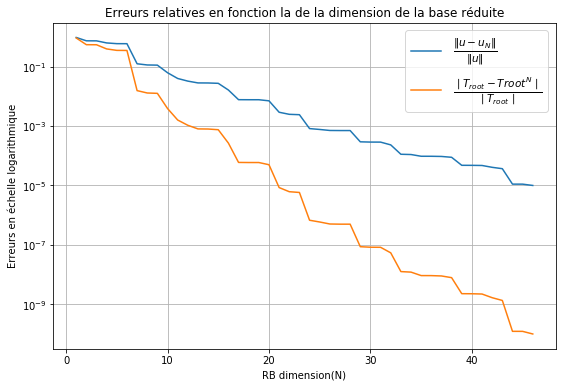

In [553]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='Erreurs en échelle logarithmique', \
       title= "Erreurs relatives en fonction la de la dimension de la base réduite")
ax.plot(range(1,47),erreur_energy,label=r"$\frac {\left \Vert u - u_N \right \Vert}{\left \Vert u  \right \Vert}$")
ax.plot(range(1,47),np.array(erreur_output),label=r"$\frac {\mid T_{root} - T{root}^N \mid}{\mid T_{root}  \mid}$")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**CPU time:**

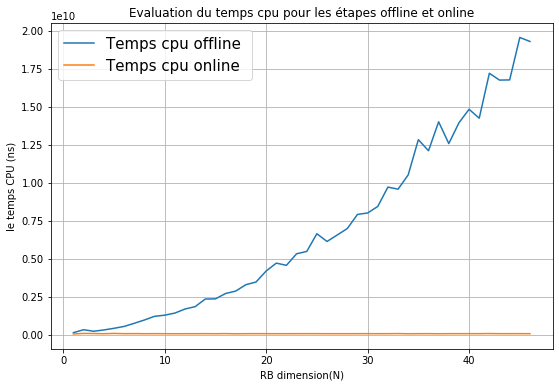

In [554]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='le temps CPU (ns)', \
       title= "Evaluation du temps cpu pour les étapes offline et online")
ax.plot(range(1,47),offline,label=r"Temps cpu offline ")
ax.plot(range(1,47),online,label=r"Temps cpu online")
#ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Comment:**

In one hand, when we change two parameters instead of one the RB dimension should be higher to reach same accuracy which was reached by N = 8 (question 1.3)for one parameter RB approximation. in the other hand, the cpu time is approximatively the same.